In [5]:
from __future__ import print_function

import re
import numpy as np
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists
import pandas as pd
import datetime, time, json

from keras.models import Model, Sequential
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization, Convolution1D, Merge, Flatten
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

In [6]:
QUESTION_PAIRS_FILE = 'data/train.csv'
GLOVE_FILE = 'data/glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'data/q1_train.npy'
Q2_TRAINING_DATA_FILE = 'data/q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'data/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'data/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'data/nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

In [7]:
STOP_WORDS = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
SAFE_DIV = 0.0001

In [8]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [9]:
question1 = []
question2 = []
is_duplicate = []
with open(QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        question1.append(preprocess(row['question1']))
        question2.append(preprocess(row['question2']))
        is_duplicate.append(row['is_duplicate'])
print('Question pairs: %d' % len(question1))

Question pairs: 404290


In [10]:
questions = question1 + question2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequences = tokenizer.texts_to_sequences(question1)
question2_word_sequences = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 91458


In [11]:
embeddings_index = {}
with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Word embeddings: 2196016


In [12]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))


Null word embeddings: 24937


In [13]:
q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(is_duplicate, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)


Shape of question1 data tensor: (404290, 25)
Shape of question2 data tensor: (404290, 25)
Shape of label tensor: (404290,)


In [14]:
np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)

In [15]:
#Model Variables
MODEL_WEIGHTS_FILE = 'question_pairs_weights_cnn_base.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32
nb_filter = 32 # Number of filters to use in Convolution1D
filter_length = 3 # Length of filter for Convolution1D
SENT_EMBEDDING_DIM = 128

In [16]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]
print("Q1_train" , len(Q1_train))
print("Q2_train" , len(Q2_train))
print("Q1_test" , len(Q1_test))
print("Q2_test" , len(Q2_test))

Q1_train 363861
Q2_train 363861
Q1_test 40429
Q2_test 40429


In [20]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)

q1 = Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same',  activation='relu')(q1)
q1 = Flatten()(q1)
#q3 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q3)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same', activation='relu')(q2)
q2 = Flatten()(q2)

merged = concatenate([q1,q2])
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 300)      27437700    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 300)      27437700    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (

In [22]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-06 22:30:27.113155
Train on 327474 samples, validate on 36387 samples
Epoch 1/25
 - 54s - loss: 0.5346 - acc: 0.7321 - val_loss: 0.5118 - val_acc: 0.7489
Epoch 2/25
 - 54s - loss: 0.4926 - acc: 0.7605 - val_loss: 0.5042 - val_acc: 0.7578
Epoch 3/25
 - 54s - loss: 0.4681 - acc: 0.7754 - val_loss: 0.5045 - val_acc: 0.7544
Epoch 4/25
 - 54s - loss: 0.4499 - acc: 0.7852 - val_loss: 0.5066 - val_acc: 0.7563
Epoch 5/25
 - 54s - loss: 0.4352 - acc: 0.7937 - val_loss: 0.5151 - val_acc: 0.7537
Epoch 6/25
 - 54s - loss: 0.4225 - acc: 0.8003 - val_loss: 0.5143 - val_acc: 0.7581
Epoch 7/25
 - 53s - loss: 0.4119 - acc: 0.8063 - val_loss: 0.5270 - val_acc: 0.7582
Epoch 8/25
 - 54s - loss: 0.4028 - acc: 0.8112 - val_loss: 0.5334 - val_acc: 0.7558
Epoch 9/25
 - 53s - loss: 0.3957 - acc: 0.8142 - val_loss: 0.5386 - val_acc: 0.7554
Epoch 10/25
 - 54s - loss: 0.3886 - acc: 0.8180 - val_loss: 0.5485 - val_acc: 0.7507
Epoch 11/25
 - 54s - loss: 0.3823 - acc: 0.8216 - val_loss: 

    epoch  training  validation
0       1  0.732110    0.748894
1       2  0.760482    0.757771
2       3  0.775420    0.754390
3       4  0.785220    0.756314
4       5  0.793739    0.753676
5       6  0.800348    0.758100
6       7  0.806330    0.758155
7       8  0.811249    0.755819
8       9  0.814175    0.755380
9      10  0.817992    0.750680
10     11  0.821555    0.746585
11     12  0.824569    0.753236
12     13  0.827501    0.746640
13     14  0.829944    0.751340
14     15  0.832112    0.755490
15     16  0.834286    0.747630
16     17  0.836140    0.750048
17     18  0.837734    0.754885
18     19  0.839154    0.750900
19     20  0.840629    0.750433
20     21  0.842528    0.750378
21     22  0.843667    0.747959
22     23  0.845386    0.752714
23     24  0.846220    0.752027
24     25  0.847545    0.751752


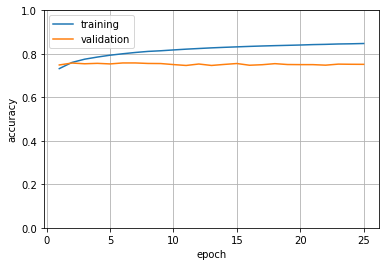

In [24]:
import matplotlib
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
print(acc)
ax = acc.iloc[:,:].plot(x='epoch',  grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [25]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))
model.load_weights(MODEL_WEIGHTS_FILE)


Maximum accuracy at epoch 7 = 0.7582


In [26]:
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.5298, accuracy = 0.7590
